In [ ]:
!pip install accelerate==0.20.3 transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 5.3 MB/s eta 0:00:00


In [ ]:
import os
os._exit(00)

In [ ]:
%%capture
!pip install datasets
!pip install rouge_score

In [ ]:
import datasets

In [ ]:
from datasets import load_dataset

dataset = load_dataset("ccdv/cnn_dailymail", '3.0.0')

Extracting data files:   0%|          | 0/5 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
# Access the train, validation, and test splits
train_data = dataset['train']
validation_data = dataset['validation']
test_data = dataset['test']

In [ ]:
len(train_data)

287113

In [ ]:
len(validation_data)

13368

In [ ]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
tokenizer.bos_token = tokenizer.cls_token
tokenizer.eos_token = tokenizer.sep_token

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
batch_size=4
gradient_accumulation_steps = 4
encoder_max_length=512
decoder_max_length=128

def process_data_to_model_inputs(batch):
  # tokenize the inputs and labels
  inputs = tokenizer(batch["article"], padding="max_length", truncation=True, max_length=encoder_max_length)
  outputs = tokenizer(batch["highlights"], padding="max_length", truncation=True, max_length=decoder_max_length)

  batch["input_ids"] = inputs.input_ids
  batch["attention_mask"] = inputs.attention_mask
  batch["decoder_input_ids"] = outputs.input_ids
  batch["decoder_attention_mask"] = outputs.attention_mask
  batch["labels"] = outputs.input_ids.copy()

  # because BERT automatically shifts the labels, the labels correspond exactly to `decoder_input_ids`.
  # We have to make sure that the PAD token is ignored
  batch["labels"] = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in batch["labels"]]

  return batch

# only use 8000 training examples for notebook
train_data = train_data.select(range(8000))

train_data = train_data.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=["article", "highlights", "id"]
)
train_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "decoder_input_ids", "decoder_attention_mask", "labels"],
)


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

In [ ]:
# only use 2000 validation examples for notebook
validation_data = validation_data.select(range(2000))

validation_data = validation_data.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=["article", "highlights", "id"]
)
validation_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "decoder_input_ids", "decoder_attention_mask", "labels"],
)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
from transformers import EncoderDecoderModel

bert2bert = EncoderDecoderModel.from_encoder_decoder_pretrained("bert-base-uncased", "bert-base-uncased")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.6.crossattention.output.dense.weight', 'bert.encoder.layer.7.crossattention.output.dense.weight', 'bert.encoder.layer.7.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.3.crossattention.self.query.bias', 'bert.encoder.layer.1.crossattention.self.key.bias', 'bert.encoder.layer.5.crossattention.self.value.weight', 'bert.encoder.layer.3.crossattention.self.query.weight', 'bert.encoder.layer.11.crossattention.self.value.weight', 'bert.encoder.layer.5.crossattention.output.dense.weight', 'bert.encoder.layer.3.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.6.crossattention.self.key.weight', 'bert.encoder.layer.9.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.9.crossattention.self.key.weight', 'bert.encoder.layer.10.crossattention.self.query.bias', 'be

In [ ]:
# set special tokens
bert2bert.config.decoder_start_token_id = tokenizer.bos_token_id
bert2bert.config.eos_token_id = tokenizer.eos_token_id
bert2bert.config.pad_token_id = tokenizer.pad_token_id

# sensible parameters for beam search
bert2bert.config.vocab_size = bert2bert.config.decoder.vocab_size
bert2bert.config.max_length = 142
bert2bert.config.min_length = 56
bert2bert.config.no_repeat_ngram_size = 3
bert2bert.config.early_stopping = True
bert2bert.config.length_penalty = 2.0
bert2bert.config.num_beams = 4

In [ ]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

In [ ]:
from datasets import load_metric

In [ ]:
# load rouge for validation
rouge = load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

<ipython-input-14-a29cc91ad435>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric("rouge")


In [ ]:
from transformers import TrainingArguments

In [ ]:
import accelerate; import transformers;

In [ ]:
print(transformers.__version__); print(accelerate.__version__)

4.35.2
0.20.3


In [ ]:
# set training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./",
    evaluation_strategy="steps",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    predict_with_generate=True,
    logging_steps=2,
    save_steps=16,
    eval_steps=4,
    warmup_steps=1,
    max_steps=16,
    overwrite_output_dir=True,
    save_total_limit=3,
)

In [ ]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    model=bert2bert,
    tokenizer=tokenizer,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=validation_data,
)
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:639: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Step,Training Loss,Validation Loss,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure
4,4.699900,2.532677,0.000400,0.000800,0.000500
8,1.897000,1.105789,0.000000,0.000100,0.000000
12,1.436200,0.841928,0.000000,0.000000,0.000000
16,1.054800,0.748309,0.000100,0.000200,0.000100


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Removed shared tensor {'decoder.cls.predictions.decoder.weight', 'decoder.cls.predictions.decoder.bias'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading


TrainOutput(global_step=16, training_loss=2.8184684365987778, metrics={'train_runtime': 7852.1763, 'train_samples_per_second': 0.008, 'train_steps_per_second': 0.002, 'total_flos': 39261062430720.0, 'train_loss': 2.8184684365987778, 'epoch': 0.01})

In [ ]:
import pandas as pd
loss = pd.DataFrame(trainer.state.log_history)

In [ ]:
loss.columns

Index(['loss', 'learning_rate', 'epoch', 'step', 'eval_loss',
       'eval_rouge2_precision', 'eval_rouge2_recall', 'eval_rouge2_fmeasure',
       'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second',
       'train_runtime', 'train_samples_per_second', 'train_steps_per_second',
       'total_flos', 'train_loss'],
      dtype='object')

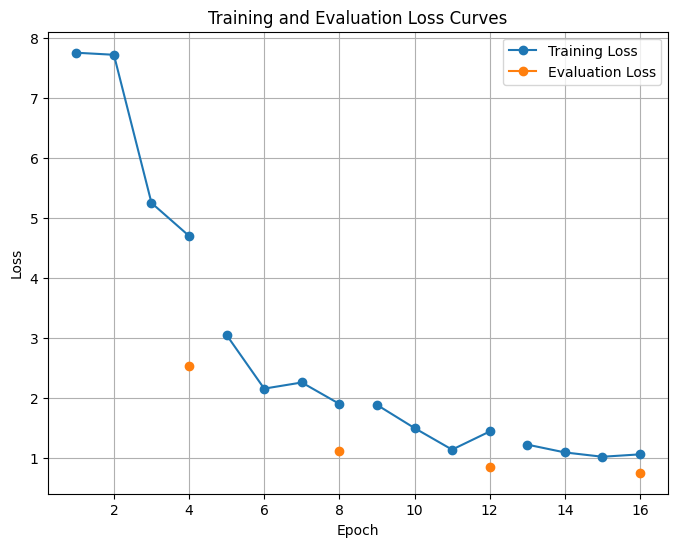

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(loss.iloc[:, 3], loss.iloc[:, 0], label='Training Loss', marker='o', linestyle='-')
plt.plot(loss.iloc[:, 3], loss.iloc[:, 4], label='Evaluation Loss', marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

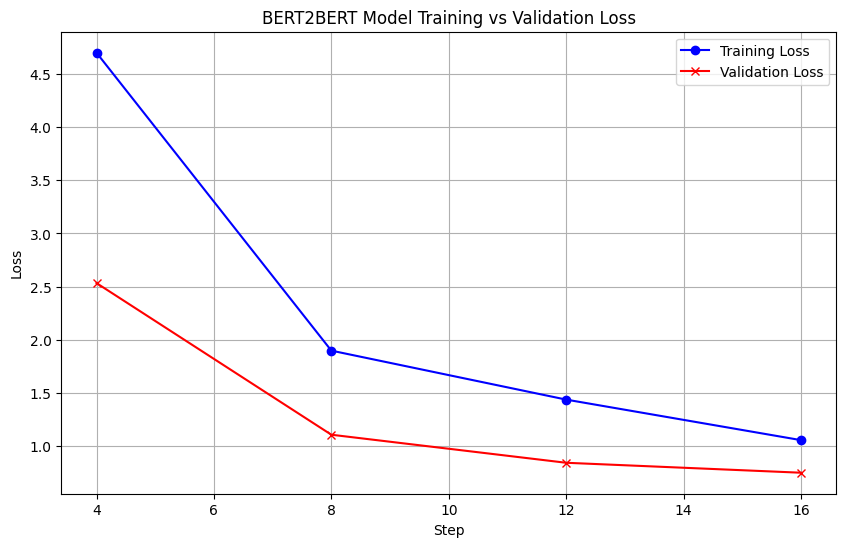

In [ ]:
import matplotlib.pyplot as plt

# Your data: Step, Training Loss, Validation Loss
steps = [4, 8, 12, 16]
training_loss = [4.699900, 1.897000, 1.436200, 1.054800]
validation_loss = [2.532677, 1.105789, 0.841928, 0.748309]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(steps, training_loss, marker='o', label='Training Loss', color='blue')
plt.plot(steps, validation_loss, marker='x', label='Validation Loss', color='red')

# Title and labels
plt.title('BERT2BERT Model Training vs Validation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


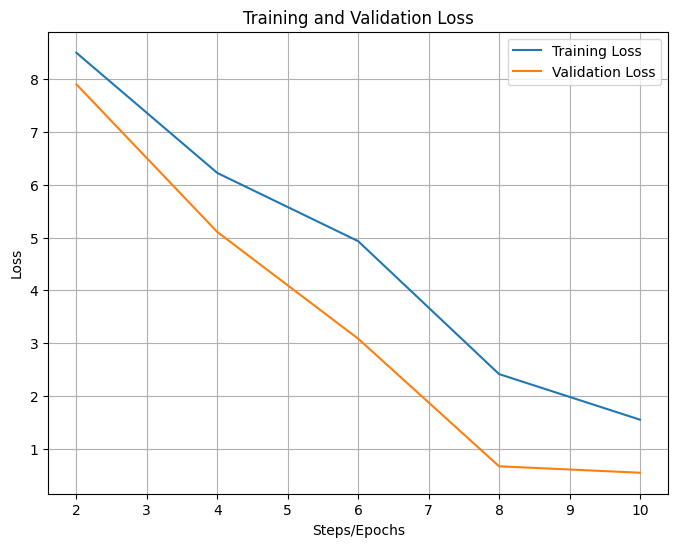

In [ ]:
import matplotlib.pyplot as plt

# Training and Validation Loss values
train_loss = [8.502200, 6.225100, 4.932300, 2.414000, 1.550200]
val_loss = [7.904778, 5.106683, 3.084764, 0.666949, 0.545380]

# Number of steps or epochs
steps = [2, 4, 6, 8, 10]

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(loss.iloc[:, 3], loss.iloc[:, 0], label='Training Loss')
plt.plot(loss.iloc[:, 3], loss.iloc[:, 4], label='Validation Loss')
plt.xlabel('Steps/Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()


In [ ]:
import datasets
from transformers import BertTokenizer, EncoderDecoderModel

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = EncoderDecoderModel.from_pretrained("./checkpoint-16")
model.to("cuda")


# we are using only 100 training examples
test_data = test_data.select(range(100))

batch_size = 16

# map data correctly
def generate_summary(batch):
    # Tokenizer will automatically set [BOS] <text> [EOS]
    # cutting off at BERT max length 512
    inputs = tokenizer(batch["article"], padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    input_ids = inputs.input_ids.to("cuda")
    attention_mask = inputs.attention_mask.to("cuda")

    outputs = model.generate(input_ids, attention_mask=attention_mask)

    # all special tokens including will be removed
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    batch["pred"] = output_str

    return batch

results = test_data.map(generate_summary, batched=True, batch_size=batch_size, remove_columns=["article"])

pred_str = results["pred"]
label_str = results["highlights"]

rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

print(rouge_output)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Score(precision=7.142857142857142e-05, recall=0.00041666666666666664, fmeasure=0.00012195121951219511)


In [ ]:
first_row = results[0]
highlights = first_row['highlights']
pred = first_row['pred']

# Print 'Actual Summary' and 'Generated Summary'
print(highlights +  "\n" "\n" + pred)

James Best, who played the sheriff on "The Dukes of Hazzard," died Monday at 88 .
"Hazzard" ran from 1979 to 1985 and was among the most popular shows on TV .

blast blast blast heat heat heat warm warm warm heat warm hot hot hot heat heat hot hot warm heat heat cold heat hot warm hot heat hot heat warm heat hot cold heat heat fire heat heat hotter hot hot cold hot heat fire hot hot fire hot heat cold hot hot coal hot heat coal hot hot hotter heat heat flames hot hot hottest heat heat coal heat hot fire heat hot coal heat heat jets hot hot firefighters hot hotz hot hot flash hot hot fires hot hot prime hot hot snow hot hot jets heat heat firefighters hot heat hotter heat hot hotter hot heat flames heat heatz hot heat firefighters heat heat fires hot heat fires heat heat steam hot hot phoenix hot hothoe hot hot sun heat heat burning hot hot burning
